# Sim-launcher
This script show how to launch sims like so: 

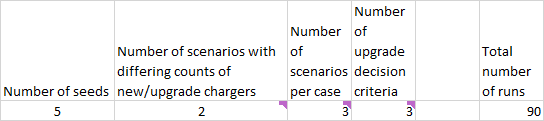

### 1. Package imports

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from pathlib import Path  # Python 3.6+ only
import os
import psycopg2
from psycopg2.extras import execute_values
import random
import time

### 2. Environment Variables

In [22]:
# Load the environment variables
env_path = Path('..') / '.env'
print(env_path)
load_dotenv(dotenv_path=env_path)
# Print this to see if the env variables are read now
os.getenv("COMPOSE_PROJECT_NAME")

../.env


'chargeval_dev'

### 3. Database connection (writer)

In [23]:
# Generic function to test the connection to the database
def connect():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:

        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(    
            host=os.getenv("MAIN_HOST"),
            database=os.getenv("MAIN_DB"),
            user=os.getenv("DBWRITE_USER"),
            password=os.getenv("DBWRITE_PWD"), 
            port = os.getenv("MAIN_PORT")
        )
		
        # create a cursor
        cur = conn.cursor()
        
	# execute a statement
        print('PostgreSQL database version:')
        cur.execute('SELECT version()')

        # display the PostgreSQL database server version
        db_version = cur.fetchone()
        print(db_version)
       
	# close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')

In [24]:
# Make the test database connection
connect()

Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 12.5 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-11), 64-bit',)
Database connection closed.


In [25]:
conn = psycopg2.connect(    
    host=os.getenv("MAIN_HOST"),
    database=os.getenv("MAIN_DB"),
    user=os.getenv("DBWRITE_USER"),
    password=os.getenv("DBWRITE_PWD"), 
    port = os.getenv("MAIN_PORT")
)

# create a cursor
cur = conn.cursor()

### 4. Database queries

#### 4.1 Base-case analysis - here refers to the data in the queries found in EVIDES

In [26]:
sql_set = 'INSERT INTO analysis_sets (description) VALUES (%s);'
set_data = 'Varying seed after upgrading max waiting # charger'

In [27]:
sql_analysis = 'INSERT INTO analysis_record (user_id, status, include_tesla) VALUES (%s, %s, %s);'
analysis_data = (os.getenv("AUTH0_USERID"), 'inserted', 'FALSE')

In [28]:
sql_user = 'INSERT INTO user_details (user_id, user_name, email_id) VALUES (%s, %s, %s) ON CONFLICT (user_id) DO UPDATE SET last_submit_date = NOW();'
user_data = (os.getenv("AUTH0_USERID"), os.getenv("AUTH0_USERNAME"), os.getenv("AUTH0_EMAIL"))

In [29]:
sql_params = 'INSERT INTO analysis_params (param_id, param_value) VALUES %s'
params_data = [(1, '123' ),(2, '70' ),(14, '10' ),(3, '80' ),(4, '100' ),(9, '40' ),(10, '50' ),(11, '25' ),(12, '23' ),(13, '20' ), (15, '1' ), ( 16, '10' ), (17, '80' ), (18, '0' ), (19, '60' ), (20, '20' ), (21, '200' )]

Launch a set of analysis requests

In [30]:
count_new_upgrade_stations = [5, 10]

In [31]:
simulation_seed = [410, 600, 210, 577, 103]

In [32]:
for i in simulation_seed:
    print(i)

410
600
210
577
103


In [33]:
set_descriptions = ["Top 5 # of charging sessions", "Top 5 # of waiting sessions", "Top 5 energy consumed" ]

---------------------------
----------------------------

## Upgrade top 5 stations with max. waiting count

In [38]:
# The order of columns in the csv is important - just change this file for launching another set of analyses
new_or_upgrade_evse_scenario = pd.read_csv('upgrade_evse_scenario_max_waiting.csv')
new_or_upgrade_evse_scenario

,latitude,longitude,dcfc_plug_count,dcfc_power,level2_plug_count,level2_power,dcfc_fixed_charging_price,dcfc_var_charging_price_unit,dcfc_var_charging_price,dcfc_fixed_parking_price,...,dcfc_var_parking_price,level2_fixed_charging_price,level2_var_charging_price_unit,level2_var_charging_price,level2_fixed_parking_price,level2_var_parking_price_unit,level2_var_parking_price,connector_code,station_type,comments
0,47.42094,-121.4113,10,50,1,10,0.5,min,0.5,0.5,...,0.5,0.5,min,0.5,0.5,min,0.5,3,upgrade,73433
1,47.42094,-121.4113,10,50,1,10,0.5,min,0.5,0.5,...,0.5,0.5,min,0.5,0.5,min,0.5,3,upgrade,167497
2,47.42094,-121.4113,10,50,1,10,0.5,min,0.5,0.5,...,0.5,0.5,min,0.5,0.5,min,0.5,3,upgrade,105362
3,47.42094,-121.4113,10,50,1,10,0.5,min,0.5,0.5,...,0.5,0.5,min,0.5,0.5,min,0.5,3,upgrade,99297
4,47.42094,-121.4113,10,50,1,10,0.5,min,0.5,0.5,...,0.5,0.5,min,0.5,0.5,min,0.5,3,upgrade,143835


In [39]:
new_or_upgrade_evse_data = [tuple(row) for row in new_or_upgrade_evse_scenario.itertuples(index=False)] 
new_or_upgrade_evse_data

[(47.42094,
  -121.4113,
  10,
  50,
  1,
  10,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  3,
  'upgrade',
  73433),
 (47.42094,
  -121.4113,
  10,
  50,
  1,
  10,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  3,
  'upgrade',
  167497),
 (47.42094,
  -121.4113,
  10,
  50,
  1,
  10,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  3,
  'upgrade',
  105362),
 (47.42094,
  -121.4113,
  10,
  50,
  1,
  10,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  3,
  'upgrade',
  99297),
 (47.42094,
  -121.4113,
  10,
  50,
  1,
  10,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  3,
  'upgrade',
  143835)]

In [40]:
sql_new_or_upgrade_evse = """INSERT INTO new_evses (latitude, longitude,
                dcfc_plug_count, dcfc_power, level2_plug_count, level2_power,
                dcfc_fixed_charging_price, dcfc_var_charging_price_unit,
                dcfc_var_charging_price, dcfc_fixed_parking_price, dcfc_var_parking_price_unit,
                dcfc_var_parking_price, level2_fixed_charging_price, level2_var_charging_price_unit,
                level2_var_charging_price, level2_fixed_parking_price, level2_var_parking_price_unit,
                level2_var_parking_price, connector_code, station_type, comments) VALUES %s"""

In [41]:
################### The following will launch 5 sims with varying seed 
#######################################################################
create_new_set = True # a boolean to encode whether to create a new set for this analysis request or add this to the previous one 
number_of_sims = 5 # launch five sims

for i in simulation_seed: 
    seed = i
    if(create_new_set):
        set_data = 'Varying seed for upgrade max waiting with 10 chargers'
        cur.execute(sql_set, (set_data, ))
    cur.execute(sql_analysis,  analysis_data)
    cur.execute(sql_user,  user_data)
    # change the seed 
    params_data.pop(0) # remove the current list element for parameter 'global_seed' (param_id = 1)
    params_data.insert(0, (1, str(seed)))
    execute_values(cur, sql_params, params_data)
    if (len(new_or_upgrade_evse_scenario.index) > 0):
        execute_values(cur, sql_new_or_upgrade_evse, new_or_upgrade_evse_data)
    create_new_set = False # since the next 4 simulations belong to the same set
    time.sleep(3) # sleep for 3 seconds so the next analysis request is 3 seconds later
    conn.commit()
    print("sim with seed:" + str(seed) + " launched")

sim with seed:410 launched
sim with seed:600 launched
sim with seed:210 launched
sim with seed:577 launched
sim with seed:103 launched


-----------------------------------------
--------------------------------------------

## New1 near top 5 stations with max. waiting count

In [46]:
# The order of columns in the csv is important - just change this file for launching another set of analyses
new_or_upgrade_evse_scenario = pd.read_csv('new1_evse_scenario_max_waiting.csv')
new_or_upgrade_evse_scenario

,latitude,longitude,dcfc_plug_count,dcfc_power,level2_plug_count,level2_power,dcfc_fixed_charging_price,dcfc_var_charging_price_unit,dcfc_var_charging_price,dcfc_fixed_parking_price,...,dcfc_var_parking_price,level2_fixed_charging_price,level2_var_charging_price_unit,level2_var_charging_price,level2_fixed_parking_price,level2_var_parking_price_unit,level2_var_parking_price,connector_code,station_type,comments
0,47.429,-121.61,10,50,1,10,0.5,min,0.5,0.5,...,0.5,0.5,min,0.5,0.5,min,0.5,3,new,73433
1,47.199,-120.96,10,50,1,10,0.5,min,0.5,0.5,...,0.5,0.5,min,0.5,0.5,min,0.5,3,new,167497
2,47.539,-120.52,10,50,1,10,0.5,min,0.5,0.5,...,0.5,0.5,min,0.5,0.5,min,0.5,3,new,105362
3,47.083,-120.74,10,50,1,10,0.5,min,0.5,0.5,...,0.5,0.5,min,0.5,0.5,min,0.5,3,new,99297
4,46.706,-122.97,10,50,1,10,0.5,min,0.5,0.5,...,0.5,0.5,min,0.5,0.5,min,0.5,3,new,143835


In [47]:
new_or_upgrade_evse_data = [tuple(row) for row in new_or_upgrade_evse_scenario.itertuples(index=False)] 
new_or_upgrade_evse_data

[(47.429,
  -121.61,
  10,
  50,
  1,
  10,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  3,
  'new',
  73433),
 (47.199,
  -120.96,
  10,
  50,
  1,
  10,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  3,
  'new',
  167497),
 (47.539,
  -120.52,
  10,
  50,
  1,
  10,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  3,
  'new',
  105362),
 (47.083,
  -120.74,
  10,
  50,
  1,
  10,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  3,
  'new',
  99297),
 (46.706,
  -122.97,
  10,
  50,
  1,
  10,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  3,
  'new',
  143835)]

In [48]:
sql_new_or_upgrade_evse = """INSERT INTO new_evses (latitude, longitude,
                dcfc_plug_count, dcfc_power, level2_plug_count, level2_power,
                dcfc_fixed_charging_price, dcfc_var_charging_price_unit,
                dcfc_var_charging_price, dcfc_fixed_parking_price, dcfc_var_parking_price_unit,
                dcfc_var_parking_price, level2_fixed_charging_price, level2_var_charging_price_unit,
                level2_var_charging_price, level2_fixed_parking_price, level2_var_parking_price_unit,
                level2_var_parking_price, connector_code, station_type, comments) VALUES %s"""

In [49]:
################### The following will launch 5 sims with varying seed 
#######################################################################
create_new_set = True # a boolean to encode whether to create a new set for this analysis request or add this to the previous one 
number_of_sims = 5 # launch five sims

for i in simulation_seed: 
    seed = i
    if(create_new_set):
        set_data = 'Varying seed for new-1 near max waiting with 10 chargers'
        cur.execute(sql_set, (set_data, ))
    cur.execute(sql_analysis,  analysis_data)
    cur.execute(sql_user,  user_data)
    # change the seed 
    params_data.pop(0) # remove the current list element for parameter 'global_seed' (param_id = 1)
    params_data.insert(0, (1, str(seed)))
    execute_values(cur, sql_params, params_data)
    if (len(new_or_upgrade_evse_scenario.index) > 0):
        execute_values(cur, sql_new_or_upgrade_evse, new_or_upgrade_evse_data)
    create_new_set = False # since the next 4 simulations belong to the same set
    time.sleep(3) # sleep for 3 seconds so the next analysis request is 3 seconds later
    conn.commit()
    print("sim with seed:" + str(seed) + " launched")

sim with seed:410 launched
sim with seed:600 launched
sim with seed:210 launched
sim with seed:577 launched
sim with seed:103 launched


_______________________________
_______________________________

## New2 near top 5 stations with max. waiting count

In [54]:
# The order of columns in the csv is important - just change this file for launching another set of analyses
new_or_upgrade_evse_scenario = pd.read_csv('new2_evse_scenario_max_waiting.csv')
new_or_upgrade_evse_scenario

,latitude,longitude,dcfc_plug_count,dcfc_power,level2_plug_count,level2_power,dcfc_fixed_charging_price,dcfc_var_charging_price_unit,dcfc_var_charging_price,dcfc_fixed_parking_price,...,dcfc_var_parking_price,level2_fixed_charging_price,level2_var_charging_price_unit,level2_var_charging_price,level2_fixed_parking_price,level2_var_parking_price_unit,level2_var_parking_price,connector_code,station_type,comments
0,47.258,-121.21,10,50,1,10,0.5,min,0.5,0.5,...,0.5,0.5,min,0.5,0.5,min,0.5,3,new,73433
1,47.076,-120.71,10,50,1,10,0.5,min,0.5,0.5,...,0.5,0.5,min,0.5,0.5,min,0.5,3,new,167497
2,47.472,-120.32,10,50,1,10,0.5,min,0.5,0.5,...,0.5,0.5,min,0.5,0.5,min,0.5,3,new,105362
3,46.947,-119.97,10,50,1,10,0.5,min,0.5,0.5,...,0.5,0.5,min,0.5,0.5,min,0.5,3,new,99297
4,46.584,-122.89,10,50,1,10,0.5,min,0.5,0.5,...,0.5,0.5,min,0.5,0.5,min,0.5,3,new,143835


In [55]:
new_or_upgrade_evse_data = [tuple(row) for row in new_or_upgrade_evse_scenario.itertuples(index=False)] 
new_or_upgrade_evse_data

[(47.258,
  -121.21,
  10,
  50,
  1,
  10,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  3,
  'new',
  73433),
 (47.076,
  -120.71,
  10,
  50,
  1,
  10,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  3,
  'new',
  167497),
 (47.472,
  -120.32,
  10,
  50,
  1,
  10,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  3,
  'new',
  105362),
 (46.947,
  -119.97,
  10,
  50,
  1,
  10,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  3,
  'new',
  99297),
 (46.584,
  -122.89,
  10,
  50,
  1,
  10,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  0.5,
  'min',
  0.5,
  3,
  'new',
  143835)]

In [56]:
sql_new_or_upgrade_evse = """INSERT INTO new_evses (latitude, longitude,
                dcfc_plug_count, dcfc_power, level2_plug_count, level2_power,
                dcfc_fixed_charging_price, dcfc_var_charging_price_unit,
                dcfc_var_charging_price, dcfc_fixed_parking_price, dcfc_var_parking_price_unit,
                dcfc_var_parking_price, level2_fixed_charging_price, level2_var_charging_price_unit,
                level2_var_charging_price, level2_fixed_parking_price, level2_var_parking_price_unit,
                level2_var_parking_price, connector_code, station_type, comments) VALUES %s"""

In [57]:
################### The following will launch 5 sims with varying seed 
#######################################################################
create_new_set = True # a boolean to encode whether to create a new set for this analysis request or add this to the previous one 
number_of_sims = 5 # launch five sims

for i in simulation_seed: 
    seed = i
    if(create_new_set):
        set_data = 'Varying seed for new-2 near max waiting with 10 chargers'
        cur.execute(sql_set, (set_data, ))
    cur.execute(sql_analysis,  analysis_data)
    cur.execute(sql_user,  user_data)
    # change the seed 
    params_data.pop(0) # remove the current list element for parameter 'global_seed' (param_id = 1)
    params_data.insert(0, (1, str(seed)))
    execute_values(cur, sql_params, params_data)
    if (len(new_or_upgrade_evse_scenario.index) > 0):
        execute_values(cur, sql_new_or_upgrade_evse, new_or_upgrade_evse_data)
    create_new_set = False # since the next 4 simulations belong to the same set
    time.sleep(3) # sleep for 3 seconds so the next analysis request is 3 seconds later
    conn.commit()
    print("sim with seed:" + str(seed) + " launched")

sim with seed:410 launched
sim with seed:600 launched
sim with seed:210 launched
sim with seed:577 launched
sim with seed:103 launched
